In [1]:
from finance_utils.electrical.china.spot.discrete.probabilistic_forecast import DiscreteSpot,ProbabilisticDiscreteCurve
from finance_utils.electrical.china.spot.discrete.testback import TestBack
from finance_utils.electrical.china.spot.rule.recycle import SampleRecycle
import numpy

In [2]:
from data_utils.stochastic_utils.distributions.baseclass import ABCDistribution
from data_utils.stochastic_utils.distributions.basic_distributions import NormalDistribution

In [3]:
quantity_min = 0
quantity_max = 30

dayahead = ProbabilisticDiscreteCurve([
    NormalDistribution(200, 9),
    NormalDistribution(201, 8),
    NormalDistribution(203, 7),
    NormalDistribution(102, 6),
])

realtime = ProbabilisticDiscreteCurve([
    NormalDistribution(200 * 1.5, 20),
    NormalDistribution(201 * 1.1, 21),
    NormalDistribution(203 * 1.2, 22),
    NormalDistribution(102 * 0.5, 53),
])

quantity = ProbabilisticDiscreteCurve([
    NormalDistribution(10, 5),
    NormalDistribution(9, 3),
    NormalDistribution(15, 1),
    NormalDistribution(25, 2),
], domain_min=quantity_min, domain_max=quantity_max)

spot = DiscreteSpot(dayahead, realtime, quantity)

In [4]:
from matplotlib import pyplot

In [5]:
trigger_rate = 0.09
punishment_rate = 0.5

In [6]:
testback = TestBack(spot.random_sample(n=50, epoch=50, use_random=True))
submitt_control = spot.quantity.value_list

In [7]:
submitt_test = testback.continuous_random_grid_search(
    spot.quantity.value_list, delta_min=-20, delta_max=20, epoch=20, rounds=20, submitted_min=0, 
    submitted_max=30, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate)[-1][0]
submitt_test2 = testback.random_grid_search(
    submitted_list= spot.quantity.value_list, 
    delta_min=-20, 
    delta_max=20, 
    epoch=400, 
    submitted_min=0, 
    submitted_max=30, 
    recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate
)[0]
submitt_test3 = testback.differential_evolution__search(
    spot.quantity.value_list,
    delta_min=-20, 
    delta_max=20,
    submitted_min=0, 
    submitted_max=30,
    recycle=SampleRecycle, 
    trigger_rate=trigger_rate,  
    punishment_rate=punishment_rate
)
submitt_test4 = spot.differential_evolution__search(
    spot.quantity.value_list,
    delta_min=-20, 
    delta_max=20,
    submitted_min=0, 
    submitted_max=30,
    recycle=SampleRecycle, 
    trigger_rate=trigger_rate,  
    punishment_rate=punishment_rate
)
print(spot.quantity.value_list)
print([submitt_test3[0].tolist(), submitt_test3[1]])
print([submitt_test4[0].tolist(), submitt_test4[1]])
print(submitt_test)
print(submitt_test2)

[10, 9, 15, 25]
[[0.0719567513347954, 27.528686825897754, 0.16705267655034461, 29.803626555136862], np.float64(9075.553244799388)]
[[0.23663273842798027, 23.19008357609122, 0.3984130668225365, 29.997368396559104], np.float64(10942.806263989289)]
[0.9223088754288611, 5.6865730978495606, 21.311261736041992, 30.0]
[2.276732068782664, 18.180161667204064, 14.238772646920328, 30]


In [8]:
noise_dayahead = ProbabilisticDiscreteCurve([
    NormalDistribution(200, 9 * 1.5),
    NormalDistribution(201, 8 * 1.5),
    NormalDistribution(203, 7 * 1.5),
    NormalDistribution(102, 6 * 1.5),
])

noise_realtime = ProbabilisticDiscreteCurve([
    NormalDistribution(200 * 1.2, 20 * 1.5),
    NormalDistribution(201 * 1.1, 21 * 1.5),
    NormalDistribution(203 * 1.2, 22 * 1.5),
    NormalDistribution(102 * 0.8, 53 * 1.5),
])

noise_quantity = ProbabilisticDiscreteCurve([
    NormalDistribution(10, 5 * 1.5),
    NormalDistribution(9, 3 * 1.5),
    NormalDistribution(15, 1 * 1.5),
    NormalDistribution(25, 2 * 1.5),
], domain_min=quantity_min, domain_max=quantity_max)
noise_spot = DiscreteSpot(dayahead, realtime, quantity)

In [9]:
rec = []
for _ in range(100):
    # temp_testback = TestBack(noise_spot.random_sample(n=50, epoch=50, use_random=True))
    temp_testback = TestBack(spot.random_sample(n=50, epoch=50, use_random=True))
    rec.append([
        temp_testback.testback_yield(submitt_control, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean(),
        temp_testback.testback_yield(submitt_test, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean(),
        temp_testback.testback_yield(submitt_test3[0], recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean(),
        temp_testback.testback_yield(submitt_test4[0], recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean(),
    ])
print(rec)

[[np.float64(7460.58132886957), np.float64(7850.131625157968), np.float64(8120.60950137655), np.float64(7757.123583444855)], [np.float64(7374.6048885085165), np.float64(8053.79263957854), np.float64(8265.773576368572), np.float64(7819.562080210254)], [np.float64(7804.621822313667), np.float64(8481.365244524664), np.float64(8640.64428283915), np.float64(7538.276589068386)], [np.float64(7491.681852299716), np.float64(8344.532534443342), np.float64(8754.421856941954), np.float64(7578.868755764598)], [np.float64(8677.78534781245), np.float64(8706.796029911295), np.float64(8992.733493315376), np.float64(7498.824620811389)], [np.float64(7192.2070444137735), np.float64(7901.240974886499), np.float64(8294.160054479586), np.float64(7689.195397492545)], [np.float64(8462.10922886047), np.float64(9388.743986555251), np.float64(9546.712868953611), np.float64(7449.170359825924)], [np.float64(8333.750327499545), np.float64(8928.98934509598), np.float64(9278.912367077368), np.float64(7901.827730239838

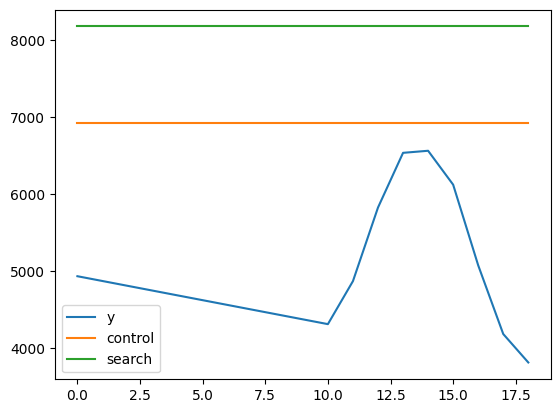

In [10]:
y_hat = [
    numpy.mean(
        temp_testback.testback_yield([i] * 4, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).yield_curve
    ) for i in range(1,20)
]
y_control = [
    numpy.mean(
        temp_testback.testback_yield(spot.quantity.value_list, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).yield_curve
    ) for i in range(1,20)
]
y_search = [
    numpy.mean(
        temp_testback.testback_yield(submitt_test3[0],
                                recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).yield_curve
    ) for i in range(1,20)
]
# pyplot.plot(y)
pyplot.plot(y_hat)
pyplot.plot(y_control)
pyplot.plot(y_search)
pyplot.legend(["y","control","search"])
pyplot.show()

In [11]:
print(noise_quantity.diff_random_sample(n=100, epoch=100).tolist())

[[14.854784073337228, 0.0, 0.0, 4.911011817265904], [20.550883697242295, 23.765698342977302, 28.42589027629454, 30.0], [18.463461157465943, 17.8416515619439, 18.479927885864942, 27.733702372705068], [6.380139559784672, 4.386189877746315, 10.599512103828955, 21.774159456068432], [11.583976061038145, 14.556856201997519, 22.44543498294233, 30.0], [11.405532473463541, 14.22309858329855, 15.488335065855928, 26.65370385269977], [12.401757949319808, 18.755906322956296, 23.85229565316677, 30.0], [0.0, 0.0, 3.620309412125067, 13.059805694493779], [5.423132772653777, 7.250499937388753, 16.478664766356196, 24.56707785562147], [6.059157434174724, 10.446005348598323, 17.13467968568887, 25.797604903576115], [0.013062303187522772, 0.0, 1.2046434092861324, 12.288268851702409], [0.0, 1.3618387704769122, 4.746393119281047, 15.757153023557878], [0.0, 0.0, 2.9942135165705617, 14.953451999710136], [19.809407738649526, 20.400975679668832, 28.318847236642714, 30.0], [3.4902932233736568, 0.0, 8.64961888938237